In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [3]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Process for motif calling with Homer

For motif calling its unclear whether it would be ideal to take all peaks activated in C57 compared to any other strain and look for motif enrichment or whether it would be better to look at motifs only in a pairwise fashion. I probably lean towards looking at any peak activated in C57 since they should be enriched for strain specific motifs.

In [4]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')
    
if not os.path.isdir('./strain_private_peaks/'):
    os.mkdir('./strain_private_peaks/')

Ty pointed out that running annotatePeaks.pl on a peak file adjusts the peak size to what is being annotated :O so we have to pull the original coordinates out of the ATAC file. The ATAC peak file from O'young's pipeline has an average peak size of about 270 so they are a little bigger than the NFR we like for ATAC seq. I'm unsure whether the best thing to do here would be to make them all 200 bp based on the center of the peak or if we should just use the merged peak sizes

In [5]:
%%bash

cp /gpfs/data01/glasslab/home/h1bennet/strains/results/00_Strains_Control_ATAC/merged_peaks/idr_peaks_merged.txt \
./

In [6]:
atac_peaks = pd.read_csv('./idr_peaks_merged.txt', sep='\t', index_col=0)

Make atac peak file with 200bp peaks set on center of current peak (rounding down if fractional center)

In [7]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

Import differential peaks from last analysis

In [8]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_output.txt',
    './ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (43605, 24)
getDiffExpression selected transcripts (42636, 33)
annotatePeaks selected peaks (42636, 24)


In [9]:
diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS'])>3000, :]

Add "browser" column to diff_peak files for saving, we dont use positional indexing later in this script so we should be fine to do this.

In [10]:
diff_peak.loc[:, 'browser'] = [i+':'+str(j)+'-'+str(k) for i,j,k in zip(diff_peak.Chr, diff_peak.Start, diff_peak.End)]
diff_peak_distal.loc[:, 'browser'] = [i+':'+str(j)+'-'+str(k) for i,j,k in zip(diff_peak_distal.Chr, diff_peak_distal.Start, diff_peak_distal.End)]

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Extract target peaks

Set cutoffs

In [11]:
# set cutoffs
fc = 1
pval = 0.05

# set comparisons
comps = ['00_c57 vs. 01_balbc', '00_c57 vs. 02_aj', '01_balbc vs. 02_aj']

C57

In [12]:
for df, text in zip([diff_peak, diff_peak_distal], ['', '_distal']):

    # negative log2fc is higher in the first group in the comparison.
    g1 = df.loc[(df.loc[:, comps[0]+' adj. p-value'] <=pval) & (df.loc[:, comps[0]+' Log2 Fold Change'] < -fc)].index.tolist()
    g2 = df.loc[(df.loc[:, comps[1]+' adj. p-value'] <=pval) & (df.loc[:, comps[1]+' Log2 Fold Change'] < -fc)].index.tolist()

    # combine activated c57 peaks
    g1.extend(g2)

    # write to csv
    atac_peaks_200bp.reindex(set(g1)).dropna().to_csv('./motif_calling/c57_act_peaks_200bp'+text+'.txt', sep='\t')
    df.reindex(set(g1)).dropna().to_csv('./strain_private_peaks/c57_private_act_peaks_200bp'+text+'.txt', sep='\t')
    
    # non activated peaks for background
    atac_peaks_200bp.reindex(diff_peak.index.difference(set(g1))).dropna().to_csv('./motif_calling/c57_bg_peaks_200bp'+text+'.txt', sep='\t')

balb

In [13]:
for df, text in zip([diff_peak, diff_peak_distal], ['', '_distal']):

    # negative log2fc is higher in the first group in the comparison.
    g1 = df.loc[(df.loc[:, comps[0]+' adj. p-value'] <=pval) & (df.loc[:, comps[0]+' Log2 Fold Change'] < -fc)].index.tolist()
    g2 = df.loc[(df.loc[:, comps[2]+' adj. p-value'] <=pval) & (df.loc[:, comps[2]+' Log2 Fold Change'] < -fc)].index.tolist()

    # combine activated balb peaks
    g1.extend(g2)

    # write to csv
    atac_peaks_200bp.reindex(set(g1)).dropna().to_csv('./motif_calling/balbc_act_peaks_200bp'+text+'.txt', sep='\t')
    df.reindex(set(g1)).dropna().to_csv('./strain_private_peaks/balbc_private_act_peaks_200bp'+text+'.txt', sep='\t')

    # non activated peaks for background
    atac_peaks_200bp.reindex(diff_peak.index.difference(set(g1))).dropna().to_csv('./motif_calling/balbc_bg_peaks_200bp'+text+'.txt', sep='\t')

aj

In [14]:
for df, text in zip([diff_peak, diff_peak_distal], ['', '_distal']):

    # negative log2fc is higher in the first group in the comparison.
    g1 = df.loc[(df.loc[:, comps[0]+' adj. p-value'] <=pval) & (df.loc[:, comps[1]+' Log2 Fold Change'] < -fc)].index.tolist()
    g2 = df.loc[(df.loc[:, comps[1]+' adj. p-value'] <=pval) & (df.loc[:, comps[2]+' Log2 Fold Change'] < -fc)].index.tolist()

    # combine activated c57 peaks
    g1.extend(g2)

    # write to csv
    atac_peaks_200bp.reindex(set(g1)).dropna().to_csv('./motif_calling/aj_act_peaks_200bp'+text+'.txt', sep='\t')
    df.reindex(set(g1)).dropna().to_csv('./strain_private_peaks/aj_private_act_peaks_200bp'+text+'.txt', sep='\t')

    # non activated peaks for background
    atac_peaks_200bp.reindex(diff_peak.index.difference(set(g1))).dropna().to_csv('./motif_calling/aj_bg_peaks_200bp'+text+'.txt', sep='\t')

### Call motifs using homer

In [175]:
%%bash
# delete the existing script file
rm ./findMotifs_homer.sh
# create a script file
touch ./findMotifs_homer.sh

In [176]:
%%bash
for i in ./motif_calling/*act*;
do bg_file=${i/act/bg};
out=${i/.txt/_motifs};
echo "findMotifsGenome.pl $i mm10 $out -bg $bg_file -len 8,10,12,14,16 -size given &" >> ./findMotifs_homer.sh
done

# Process in  Maggie

Here we just want to take peaks that are increased specifically in one strain when compared to another, but i would prefer to do this all in one go so that we can pool our power. Perhaps we can start by doing everything relevant to C57 - this would introduce duplicate peaks which could affect our overall power

To do this part it helps to have some understanding of the diffpeak file that homer puts out... the columns at the end are "group1 vs group2" with p value and log2fold change. The log2fold change here looks like this:  \

$\log2(\frac{group2 tags}{group1 tags})$  

So in this case things that are higher in group 1 will be negative and things that are higher in group 2 will be positive. Since C57 is group 1 in this case it all negative peaks will be up in C57

In [18]:
if not os.path.isdir('./differential_peaks/'):
    os.mkdir('./differential_peaks/')

In [19]:
comps = ['00_c57 vs. 01_balbc', '00_c57 vs. 02_aj', '01_balbc vs. 02_aj']

In [20]:
# set cutoffs
fc = 1
pval = 0.05

for df, text in zip([diff_peak, diff_peak_distal], ['', '_distal']):
    print(text, 'analysis')
    for comp in comps:
        # extract strains
        s1 = comp.split(' vs. ')[0].split('_')[1]
        s2 = comp.split(' vs. ')[1].split('_')[1]

        # write group 2 activated
        g1 = df.loc[(df.loc[:, comp+' adj. p-value'] <=pval) & (df.loc[:, comp+' Log2 Fold Change'] < -fc)].index.tolist()
        print(len(g1), 'peaks upregualted in', s1, 'relative to', s2)
        atac_peaks_200bp.loc[g1, :].to_csv('./differential_peaks/'+s1+'_spec_'+s2+'_200bp'+text+'.txt', sep='\t')

        g2 = df.loc[(df.loc[:, comp+' adj. p-value'] <=pval) & (df.loc[:, comp+' Log2 Fold Change'] > fc)].index.tolist()
        print(len(g2), 'peaks upregualted in', s2, 'relative to', s1)
        atac_peaks_200bp.loc[g2, :].to_csv('./differential_peaks/'+s2+'_spec_'+s1+'_200bp'+text+'.txt', sep='\t')

 analysis
1272 peaks upregualted in c57 relative to balbc
1084 peaks upregualted in balbc relative to c57
1389 peaks upregualted in c57 relative to aj
831 peaks upregualted in aj relative to c57
548 peaks upregualted in balbc relative to aj
329 peaks upregualted in aj relative to balbc
_distal analysis
963 peaks upregualted in c57 relative to balbc
877 peaks upregualted in balbc relative to c57
1101 peaks upregualted in c57 relative to aj
671 peaks upregualted in aj relative to c57
443 peaks upregualted in balbc relative to aj
247 peaks upregualted in aj relative to balbc


Extract sequences for maggie

In [22]:
if not os.path.isdir('./differential_fasta/'):
    os.mkdir('./differential_fasta/')

In [ ]:
### c57 vs balb
marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_c57_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_c57_ref_200bp.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_spec_c57_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_c57_mut_200bp.fa

marge extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_balbc_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_balbc_ref_200bp.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/c57_spec_balbc_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_balbc_mut_200bp.fa

# distal

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_c57_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_spec_c57_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa

marge extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_balbc_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/c57_spec_balbc_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa

### balb vs aj

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_aj_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_aj_ref_200bp.fa
marge extract_sequences -ind AJ -file ./differential_peaks/balbc_spec_aj_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_aj_mut_200bp.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_spec_balbc_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_balbc_ref_200bp.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/aj_spec_balbc_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_balbc_mut_200bp.fa

# distal

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_aj_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa
marge extract_sequences -ind AJ -file ./differential_peaks/balbc_spec_aj_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_spec_balbc_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/aj_spec_balbc_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa

### c57 vs aj

marge extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_aj_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_aj_ref_200bp.fa
marge extract_sequences -ind AJ -file ./differential_peaks/c57_spec_aj_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_aj_mut_200bp.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_spec_c57_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_c57_ref_200bp.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/aj_spec_c57_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_c57_mut_200bp.fa

# distal

marge extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_aj_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_aj_ref_200bp_distal.fa
marge extract_sequences -ind AJ -file ./differential_peaks/c57_spec_aj_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_aj_mut_200bp_distal.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_spec_c57_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_c57_ref_200bp_distal.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/aj_spec_c57_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_c57_mut_200bp_distal.fa


# Try running maggie with aggregated peaks

In [23]:
if not os.path.isdir('./maggie_output/'):
    os.mkdir('./maggie_output/')

balbc vs c57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa \
-o ./maggie_output/balbc_c57_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/balbc_c57_200bp_distal/ \
-p 20

aj vs c57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa \
./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa \
-o ./maggie_output/aj_c57_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa \
./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa \
-o ./maggie_output/aj_c57_200bp_distal/ \
-p 20

balbc vs aj

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_aj_ref_200bp.fa,./differential_fasta/aj_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_aj_mut_200bp.fa,./differential_fasta/aj_spec_balbc_mut_200bp.fa \
-o ./maggie_output/balbc_aj_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa,./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa,./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/balbc_ajnew_200bp_distal/ \
-p 20

all c57 involved comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa,./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa,./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa \
-o ./maggie_output/c57_vs_all_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa,./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa,./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa \
-o ./maggie_output/c57_vs_all_200bp_distal/ \
-p 20

all comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa,./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa,./differential_fasta/balbc_spec_aj_ref_200bp.fa,./differential_fasta/aj_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa,./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa,./differential_fasta/balbc_spec_aj_mut_200bp.fa,./differential_fasta/aj_spec_balbc_mut_200bp.fa \
-o ./maggie_output/all_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa,./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa,./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa,./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa,./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa,./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa,./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/all_200bp_distal/ \
-p 20

# Aggregate results - Homer

In [7]:
glob.glob('./motif_calling/*motifs/knownResults.txt')

['./motif_calling/balbc_act_peaks_200bp_motifs/knownResults.txt',
 './motif_calling/balbc_act_peaks_200bp_distal_motifs/knownResults.txt',
 './motif_calling/c57_act_peaks_200bp_motifs/knownResults.txt',
 './motif_calling/c57_act_peaks_200bp_distal_motifs/knownResults.txt',
 './motif_calling/aj_act_peaks_200bp_motifs/knownResults.txt',
 './motif_calling/aj_act_peaks_200bp_distal_motifs/knownResults.txt']

In [178]:
known_motif_pval_dict = {}
for f in glob.glob('./motif_calling/*distal_motifs/knownResults.txt'):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_distal_log.txt', sep='\t')

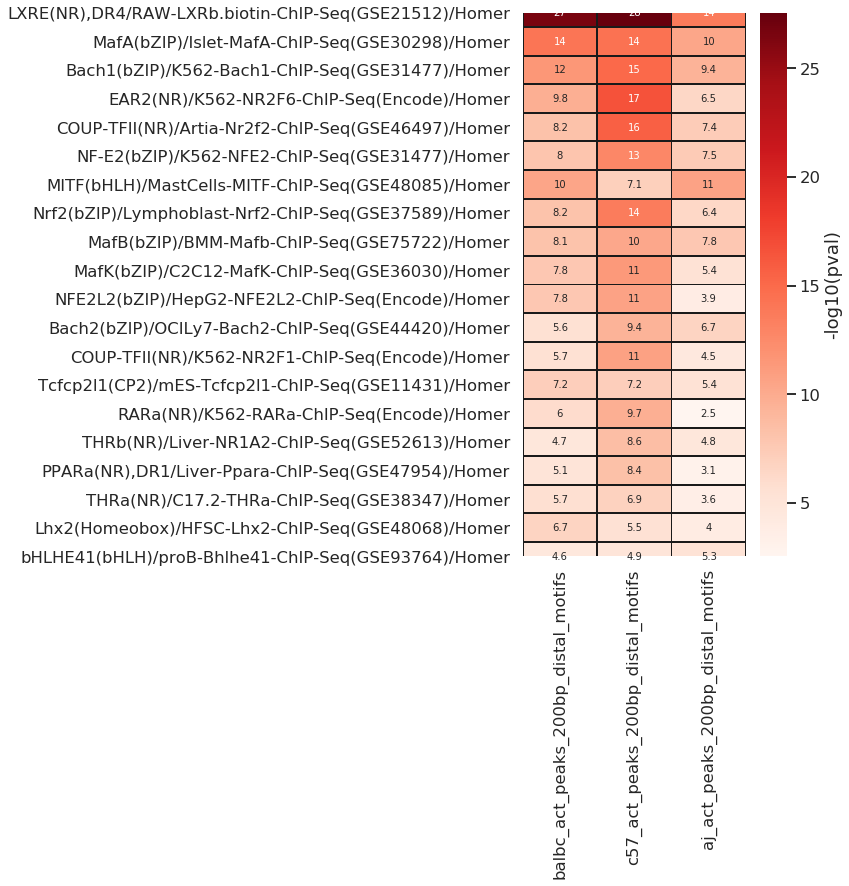

In [186]:
fig, ax = plt.subplots(figsize=(5,10))

sns.heatmap(
    -known_motif_pval_frame.loc[(known_motif_pval_frame <=np.log10(0.00001)).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    ax=ax)

# Aggregate results - maggie

All enhancers

In [17]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*c57*200bp/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-2
filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

Plot top 30 motifs upregulated

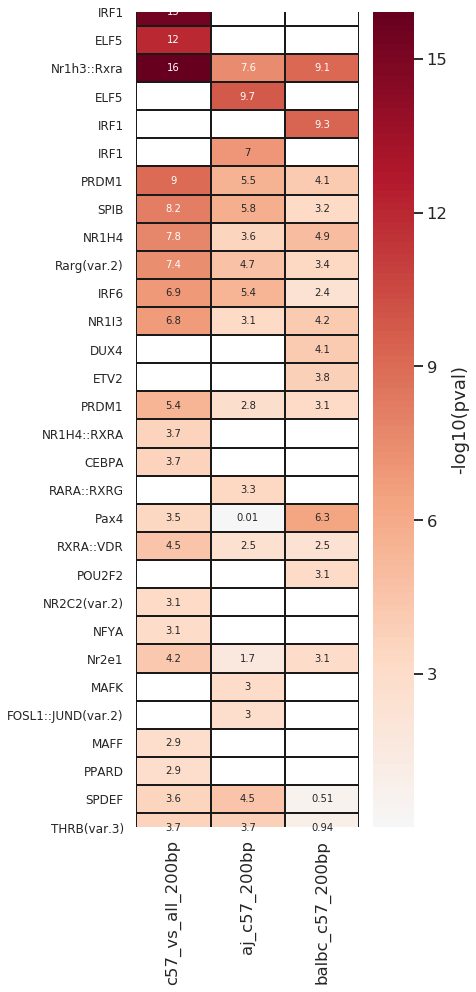

In [21]:
fig, ax = plt.subplots(figsize=(5,15))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) > 0), :].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.loc[(filtered_frame.mean(1) > 0), :].index.values, rotation=0);

plt.savefig('./figures/maggie_activated_motifs_merged.png', bbox_inches='tight')

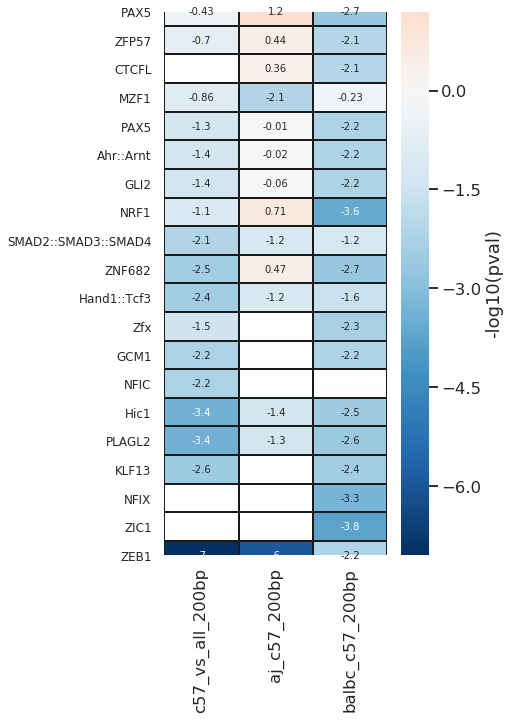

In [22]:
fig, ax = plt.subplots(figsize=(5,10))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) < 0), :].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12,
                   labels=filtered_frame.loc[(filtered_frame.mean(1) < 0), :].index.values,
                   rotation=0);

plt.savefig('./figures/maggie_repressing_motifs_merged.png', bbox_inches='tight')

### Distal enhancers

In [24]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*c57*200bp_distal/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-2
# filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

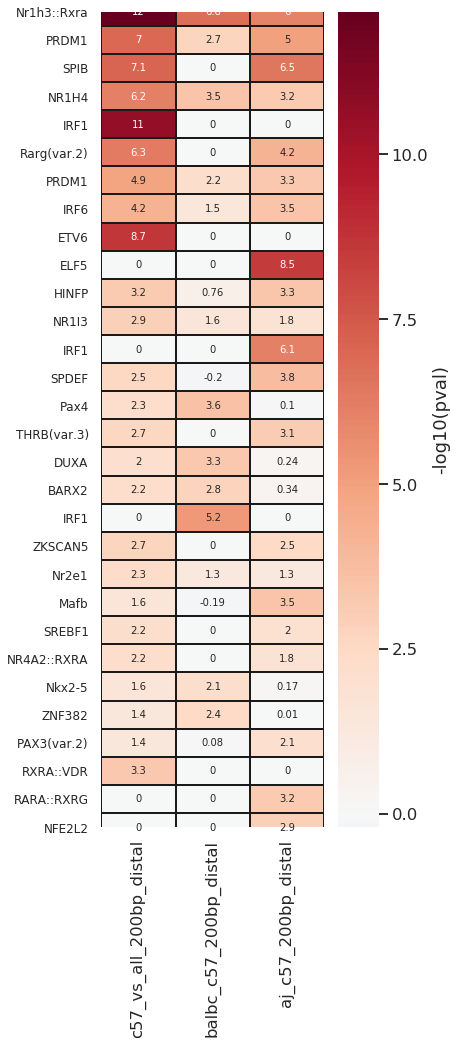

In [25]:
fig, ax = plt.subplots(figsize=(5,15))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) > 0), :].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged.png', bbox_inches='tight')

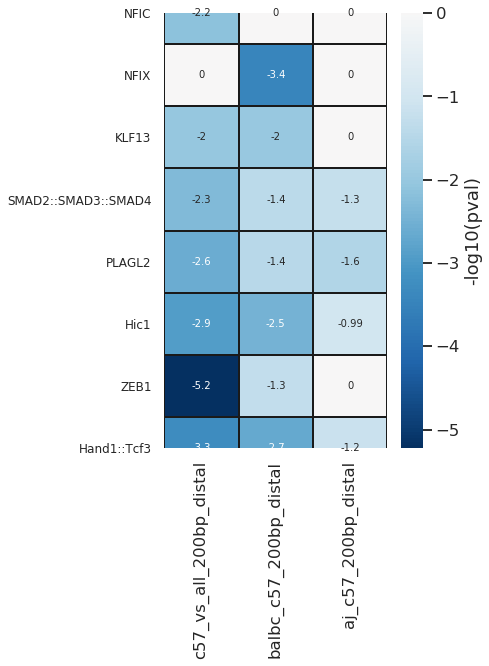

In [27]:
fig, ax = plt.subplots(figsize=(5,8))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) < 0), :].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.loc[(filtered_frame.mean(1) < 0), :].index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged.png', bbox_inches='tight')

### Plot with just the top motifs from c57_vs_all 

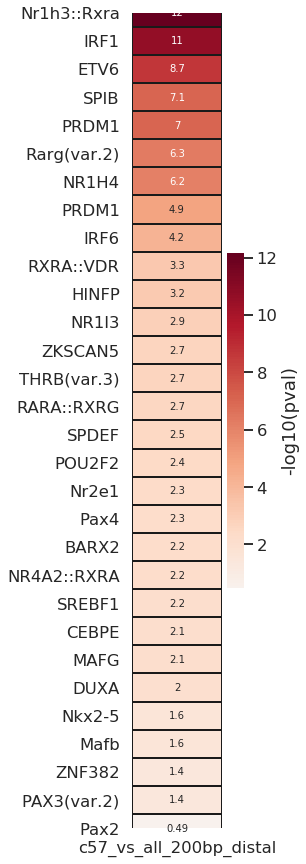

In [29]:
fig, ax = plt.subplots(figsize=(2,15))

filtered_frame = filtered_frame.sort_values('c57_vs_all_200bp_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['c57_vs_all_200bp_distal']].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged_c57_vs_all.png', bbox_inches='tight')

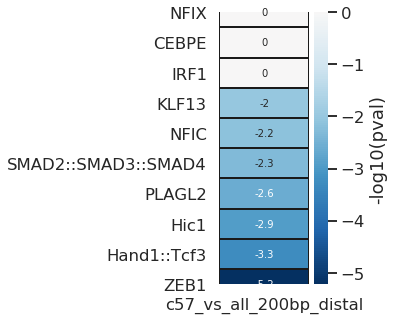

In [31]:
fig, ax = plt.subplots(figsize=(2,5))

filtered_frame = filtered_frame.sort_values('c57_vs_all_200bp_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['c57_vs_all_200bp_distal']].tail(10),
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged_c57_vs_all.png', bbox_inches='tight')

# repeat with  unmerged motifs

In [176]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*c57*200bp/maggie_output.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        df = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = df.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-10
filtered_frame = frame.loc[(np.abs(frame) > 20).any(1), :]

# replace NaN with 0
filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

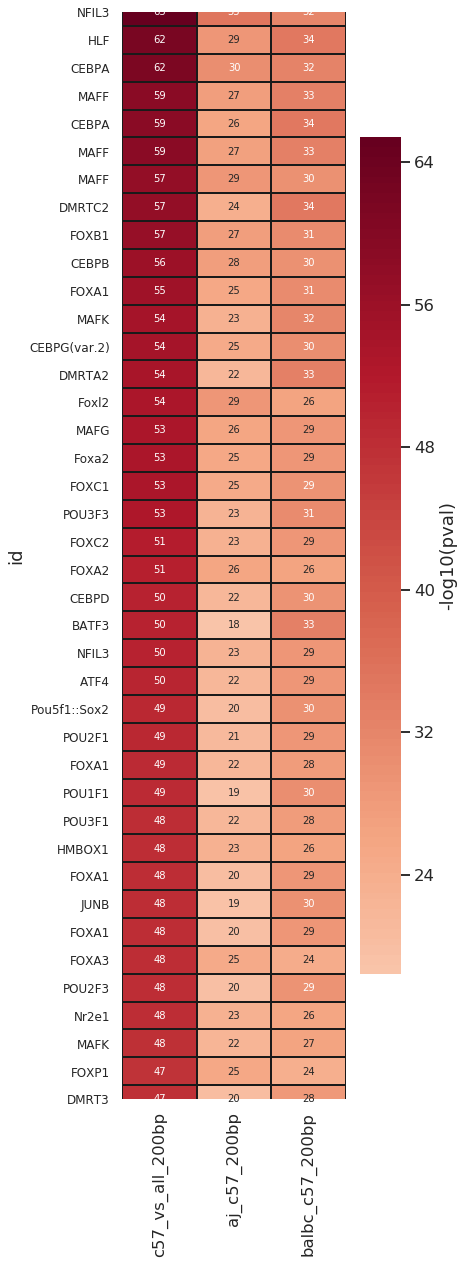

In [177]:
fig, ax = plt.subplots(figsize=(5,20))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1)) > 0, :].head(40),
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=df.loc[filtered_frame.index.values,'motif'], rotation=0);

plt.savefig('./figures/maggie_activated_motifs.png', bbox_inches='tight')

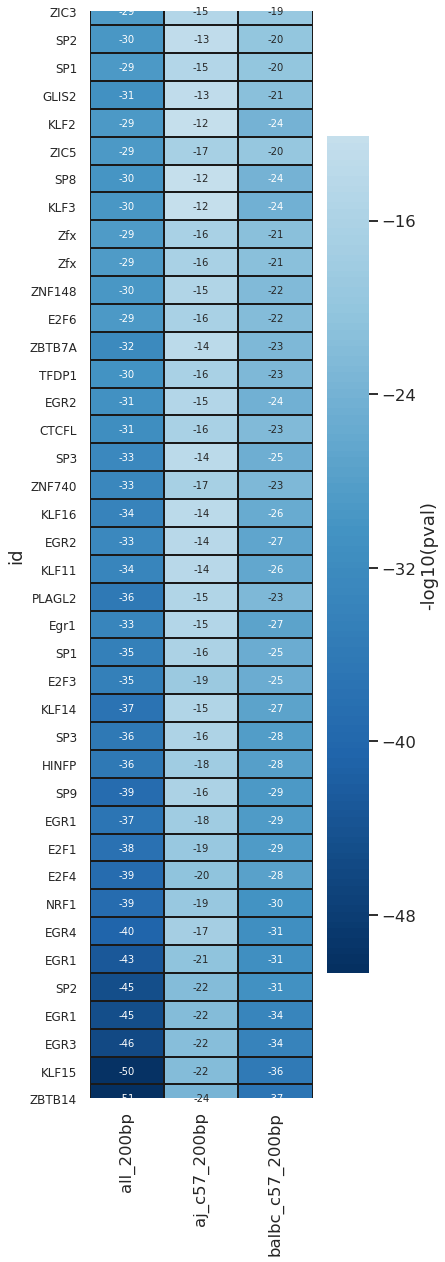

In [151]:
fig, ax = plt.subplots(figsize=(5,20))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1)) < 0, :].tail(40),
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=df.loc[filtered_frame.loc[(filtered_frame.mean(1)) < 0, :].tail(40).index.values,'motif'], rotation=0);

plt.savefig('./figures/maggie_repressed_motifs.png', bbox_inches='tight')

# Plot motifs

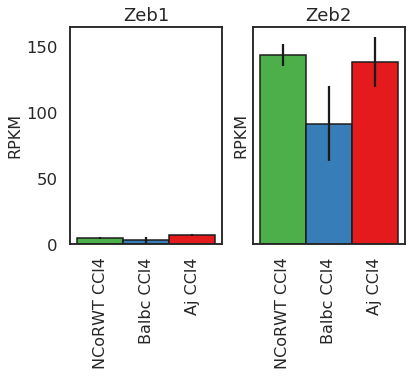

In [18]:
fig, axs = plt.subplots(1,2,figsize=(6,4), sharex=True, sharey=True)

count=0

for i in ['Zeb1', 'Zeb2']:
    survey_strain_ccl4_gene_exp(i, ax=axs.flatten()[count])
    count+=1

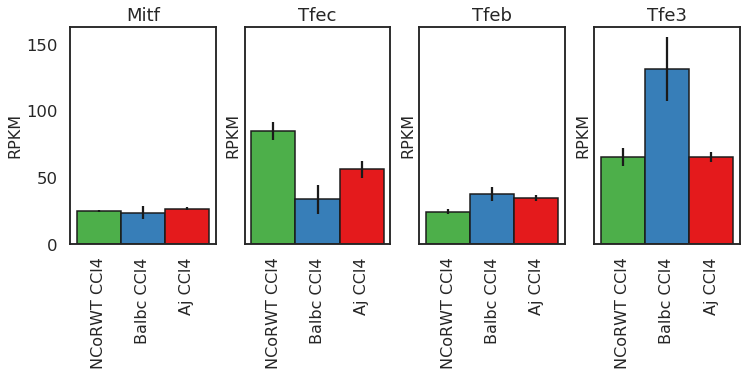

In [19]:
fig, axs = plt.subplots(1,4,figsize=(12,4), sharex=True, sharey=True)

count=0

for i in ['Mitf', 'Tfec', 'Tfeb', 'Tfe3']:
    survey_strain_ccl4_gene_exp(i, ax=axs.flatten()[count])
    count+=1